## Get file artifacts


In [24]:
import git
import os
import tempfile
import shutil
import time

# Repository URL
REPO_URL = 'https://github.com/brunoalmiron/mbd-elevator.git'
# Development branch to be analysed as current
CURR_DEV = 'dev-0.3'
# Release tag for development branch
CURR_TAG = 'v0.3.0'
# Files to be looked for
INSPECT_FILES = {
    'Requisitos': ['docs/artifacts/requirements.md', 'REQ'],
    'Especificações' :['docs/artifacts/specifications.md', 'SPEC'],
    'Casos de teste': ['docs/artifacts/testcase.md', 'TCASE'],
    'Procedimentos de teste': ['docs/artifacts/testprocedure.md', 'TPROD']
}

def get_artifacts(file_path: str, artifact_key: str):
    try:
        with open(file_path, 'r') as data_file:
            data = data_file.read()
        arts = [art.strip() for art in data.split('##')]
        return [art for art in arts if art.startswith(artifact_key)]
    except FileNotFoundError:
        return []

def analyze_repository(repo_dir):
    artifacts = {}
    for key,val in INSPECT_FILES.items():
        file_path = os.path.join(repo_dir, val[0])
        art_key = val[1]
        artifacts[key] = get_artifacts(os.path.join(repo_dir, file_path), art_key)
    return artifacts

def wait_for_files(repo_dir, files, timeout=1):
    start_time = time.time()
    while time.time() - start_time < timeout:
        if all(os.path.exists(os.path.join(repo_dir, file)) for file in files):
            return True
        time.sleep(1)
    return False

# Crie um diretório temporário
temp_dir = tempfile.mkdtemp()

try:
    # Clone o repositório no diretório temporário
    repo_dir = os.path.join(temp_dir, 'tmp')
    repo = git.Repo.clone_from(REPO_URL, repo_dir)

    # Liste todas as tags
    tags = repo.tags
    # Inclui branch de desenvolvimento atual
    tags.append(CURR_DEV)

    # Dicionário para armazenar os resultados
    all_artifacts = {}

    # Itere sobre cada tag e aplique a análise
    for tag in tags:
        print(f"Processando tag: {tag}")
        repo.git.checkout(tag)
        all_artifacts[str(tag)] = analyze_repository(repo_dir)

finally:
    # Apague o diretório temporário
    try:
        shutil.rmtree(temp_dir)
    except Exception as e:
        print(f"Erro ao remover o diretório temporário: {e}")

# Substituir a chave da última iteração pela tag que será adicionada
all_artifacts[CURR_TAG] = all_artifacts.pop(CURR_DEV)

# Exibir os resultados
for tag, artifacts in all_artifacts.items():
    print(f"Resultados para {tag}:")
    for key, value in artifacts.items():
        print(f"{key}: {value}")

Processando tag: v0.1.0
Processando tag: v0.2.0
Processando tag: dev-0.3
Erro ao remover o diretório temporário: [WinError 5] Access is denied: 'C:\\Users\\rodri\\AppData\\Local\\Temp\\tmpxyle48yl\\tmp\\.git\\objects\\pack\\pack-03d4c29d84fe443a7d06a4de54028b53471d906c.idx'
Resultados para v0.1.0:
Requisitos: []
Especificações: []
Casos de teste: []
Procedimentos de teste: []
Resultados para v0.2.0:
Requisitos: ['REQ-01\n\n!!! requirement "Conforto de OperaÃ§Ã£o"\n    !!! description "DescriÃ§Ã£o"\n        A <u>__ABNT__</u> determina que, dado um sistema de elevador:\n        ```quote\n        O sistema deve apresentar operaÃ§Ã£o confortÃ¡vel, com\n        aceleraÃ§Ã£o e desaceleraÃ§Ã£o suaves, sem trancos ou solvancos.\n        ```\n    !!! links "Artefatos Relacionados"\n        - Derivado em :octicons-arrow-right-24: [REQ-05 Conforto de OperaÃ§Ã£o - AceleraÃ§Ã£o](#req-05)\n        - Derivado em :octicons-arrow-right-24: [REQ-06 Conforto de OperaÃ§Ã£o - Jitter](#req-06)\n        - Te

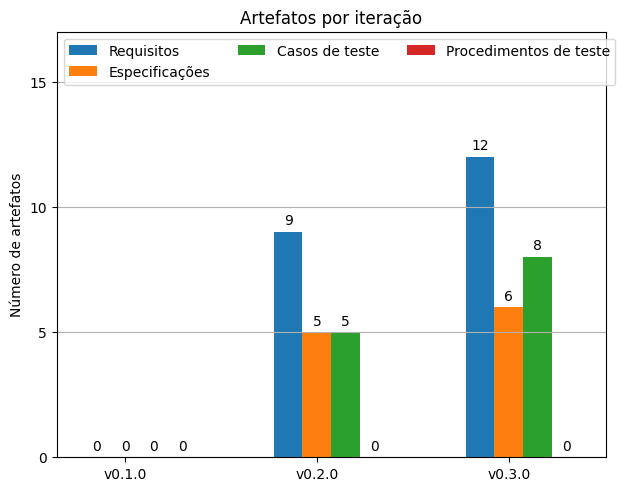

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Obtenha os índices das iterações (tags)
iteration_indexes = list(all_artifacts.keys())

# Inicialize a série de artefatos
artifacts_series = {title: [] for title in all_artifacts[iteration_indexes[0]].keys()}

# Preencha a série de artefatos com os dados das iterações
for iteration in iteration_indexes:
    for title, values in all_artifacts[iteration].items():
        artifacts_series[title].append(len(values))

x = np.arange(len(iteration_indexes))
width = 0.15
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in artifacts_series.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Adicione rótulos e título
ax.set_ylabel('Número de artefatos')
ax.set_title('Artefatos por iteração')
ax.set_xticks(x + width, iteration_indexes)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, max(max(measurement) for measurement in artifacts_series.values()) + 5)
ax.set_yticks(range(0, max(max(measurement) for measurement in artifacts_series.values()) + 6, 5))
ax.grid(True,'both','y')

plt.show()

In [27]:
fig.savefig("../docs/assets/plots/artifact_seriesv0.3.0.svg")